# Lemon Farm - Customer Segmentation

### Import library

In [115]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np


### Read data from postgreSQL

In [116]:
conn = psycopg2.connect(
    dbname="nay-krit",
    user="nay-krit",
    password="1111",
    host="sql.dfhead.com",
    port= 5432
)

sql_query = "SELECT * FROM lf_data"
lf_data_ori = pd.read_sql(sql_query, conn)

conn.close()


C:\Users\User\AppData\Local\Temp\ipykernel_10848\4280691889.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  lf_data_ori = pd.read_sql(sql_query, conn)


In [117]:
lf_data_ori.info()
lf_data_ori.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bill_date    2800 non-null   object 
 1   bill_time    2800 non-null   object 
 2   bill_no      2800 non-null   object 
 3   member_id    1603 non-null   object 
 4   sku_code     2800 non-null   object 
 5   sku_name     2800 non-null   object 
 6   qty          2800 non-null   int64  
 7   sales        2800 non-null   float64
 8   sex          1385 non-null   object 
 9   age          1601 non-null   float64
 10  location     1601 non-null   object 
 11  cat_code     2800 non-null   object 
 12  category     2748 non-null   object 
 13  day_name     2800 non-null   object 
 14  time_of_day  2800 non-null   object 
dtypes: float64(2), int64(1), object(12)
memory usage: 328.2+ KB


,bill_date,bill_time,bill_no,member_id,sku_code,sku_name,qty,sales,sex,age,location,cat_code,category,day_name,time_of_day
0,2022-09-07,11:17:24 น.,e76360ed,None,7009018,ลาเต้เย็น 240 ml#ขวด,1,79.8579,None,NaN,None,7009,Coffee (Bottle),2_Wednesday,1_Noon
1,2022-09-07,08:35:22 น.,a6bd1288,14bc04ee,7009018,ลาเต้เย็น 240 ml#ขวด,1,79.8579,F,59.0,North,7009,Coffee (Bottle),2_Wednesday,0_Morning
2,2022-09-07,08:51:39 น.,ac1311ce,None,7009018,ลาเต้เย็น 240 ml#ขวด,1,79.8579,None,NaN,None,7009,Coffee (Bottle),2_Wednesday,0_Morning
3,2022-09-07,14:22:55 น.,4f889f95,8e60e131,7009018,ลาเต้เย็น 240 ml#ขวด,1,79.8579,M,57.0,North,7009,Coffee (Bottle),2_Wednesday,2_Afternoon
4,2022-09-07,17:23:21 น.,69cb0d58,2c156018,7009017,อเมริกาโน่เย็น 240 ml#ขวด,1,79.8579,M,41.0,North,7009,Coffee (Bottle),2_Wednesday,2_Afternoon


## Experiment 1
menu category clustering

In [118]:
lf_data = lf_data_ori[['member_id', 'sales', 'category']].copy()
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  1603 non-null   object 
 1   sales      2800 non-null   float64
 2   category   2748 non-null   object 
dtypes: float64(1), object(2)
memory usage: 65.8+ KB


,member_id,sales,category
0,None,79.8579,Coffee (Bottle)
1,14bc04ee,79.8579,Coffee (Bottle)
2,None,79.8579,Coffee (Bottle)
3,8e60e131,79.8579,Coffee (Bottle)
4,2c156018,79.8579,Coffee (Bottle)


In [119]:
lf_data = lf_data.dropna()
lf_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1574 entries, 1 to 2797
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  1574 non-null   object 
 1   sales      1574 non-null   float64
 2   category   1574 non-null   object 
dtypes: float64(1), object(2)
memory usage: 49.2+ KB


In [120]:
aggregations = {
    'sales': 'sum',
    'category': 'max'
}
lf_data = lf_data.groupby('member_id').agg(aggregations).reset_index()
lf_data.info()
lf_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  1036 non-null   object 
 1   sales      1036 non-null   float64
 2   category   1036 non-null   object 
dtypes: float64(1), object(2)
memory usage: 24.4+ KB


,member_id,sales,category
0,004a4488,234.5826,Salad
1,009e11b6,71.5453,Salad
2,00f07ddd,209.6270,Salad
3,00f0e4d4,117.2913,Salad
4,0100b137,117.3002,Salad


In [121]:
lf_data = lf_data.drop('member_id', axis=1)
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     1036 non-null   float64
 1   category  1036 non-null   object 
dtypes: float64(1), object(1)
memory usage: 16.3+ KB


,sales,category
0,234.5826,Salad
1,71.5453,Salad
2,209.6270,Salad
3,117.2913,Salad
4,117.3002,Salad


In [122]:
lf_data = pd.get_dummies(lf_data, columns=['category'], prefix=['category'])
lf_data = lf_data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sales                     1036 non-null   float64
 1   category_Coffee           1036 non-null   int32  
 2   category_Coffee (Bottle)  1036 non-null   int32  
 3   category_Honey1           1036 non-null   int32  
 4   category_Juice            1036 non-null   int32  
 5   category_Salad            1036 non-null   int32  
 6   category_Salmon Steak     1036 non-null   int32  
 7   category_Soup             1036 non-null   int32  
 8   category_Tea              1036 non-null   int32  
dtypes: float64(1), int32(8)
memory usage: 40.6 KB


,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
0,234.5826,0,0,0,0,1,0,0,0
1,71.5453,0,0,0,0,1,0,0,0
2,209.6270,0,0,0,0,1,0,0,0
3,117.2913,0,0,0,0,1,0,0,0
4,117.3002,0,0,0,0,1,0,0,0


In [123]:
scale = MinMaxScaler()
lf_data_scale = lf_data.copy()
lf_data_scale[lf_data_scale.columns] = scale.fit_transform(lf_data)
lf_data_scale.head()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
0,0.127180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.017377,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.110373,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.048186,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.048192,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [124]:
def Silhouette_coef(df):
    Num_K = [i+2 for i in range(9)]
    silhouette_coef = []

    for k in Num_K:
        kmeans = KMeans(n_clusters=k, random_state=1,)
        model = kmeans.fit(df)
        labels = model.labels_
        silhouette_coef.append(metrics.silhouette_score(df, labels, metric='euclidean'))
        silhouette_coef
    print(Num_K,silhouette_coef)
    plt.scatter(Num_K,silhouette_coef)
    plt.plot(Num_K,silhouette_coef)
    plt.title('Silhouette coefficients')
    plt.ylabel('Scores')
    plt.xlabel('k')
    plt.show()

In [125]:
def wcss(df):
    Num_K = [i+2 for i in range(9)]
    WCSS = []

    for k in Num_K:
        kmeans = KMeans(n_clusters=k, random_state=1,)
        model = kmeans.fit(df)
        WCSS.append(model.inertia_)
        WCSS
    print(Num_K, WCSS)
    plt.scatter(Num_K,WCSS )
    plt.plot(Num_K,WCSS )
    plt.title('WCSS')
    plt.ylabel('Scores')
    plt.xlabel('k')
    plt.show()

### Silhouette_coef

[2, 3, 4, 5, 6, 7, 8, 9, 10] [0.7005239228155206, 0.755103365253007, 0.8709715277708445, 0.8972982154883672, 0.9195826304660182, 0.9416522553987309, 0.950230672685227, 0.9305256982145604, 0.9303007492866779]


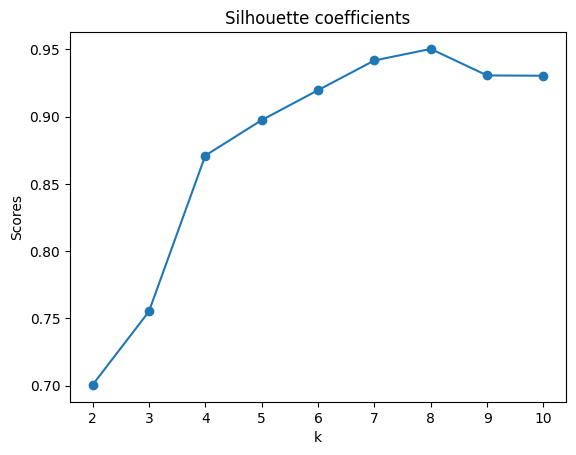

In [126]:
Silhouette_coef(lf_data_scale)

### wcss

[2, 3, 4, 5, 6, 7, 8, 9, 10] [283.4600842646007, 222.4459984309375, 96.93568277630209, 66.3660721872707, 41.08265564406203, 16.859169263613982, 8.302875061975367, 7.496553071024664, 6.234647347960244]


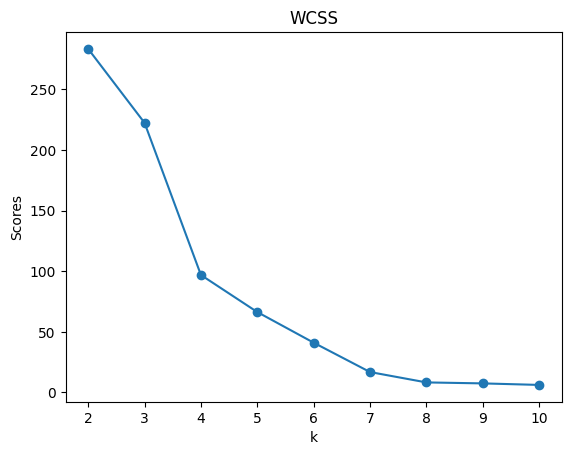

In [127]:
wcss(lf_data_scale)

In [128]:
def pca_plot(df, colors):
    pca_2 = PCA(n_components=2)
    pca_2_result = pca_2.fit_transform(df)
    print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
    print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
    dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=df.columns, index=['PC_1', 'PC_2'])
    print('\n\n', dataset_pca)

    print("\n*************** Most important features *************************")
    print('As per PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())
    print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
    print("\n******************************************************************")

    x = pca_2_result[:, 0]
    y = pca_2_result[:, 1]

    plt.scatter(x, y, c=[colors[i] for i in kmeans.labels_], alpha=0.5, s=300)  # plot different colors per cluster
    plt.title('clusters')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    
    centroids_pca = pca_2.transform(kmeans.cluster_centers_)
    for i in range(len(centroids_pca)):
        plt.scatter(centroids_pca[i, 0], centroids_pca[i, 1], marker='X', s=80, linewidths=1.5,color=colors[i], edgecolors="black")
    

    plt.show()
    

### kmean

In [129]:
kmeans = KMeans(n_clusters=4, random_state=1,)
model = kmeans.fit(lf_data_scale)
labels = model.labels_

### pca plot

Explained variation per principal component: [0.52318559 0.21533477]
Cumulative variance explained by 2 principal components: 73.85%


          sales  category_Coffee  category_Coffee (Bottle)  category_Honey1  \
PC_1  0.004347         0.298762                  0.371088         0.017709   
PC_2  0.009307         0.705874                  0.705573         0.004331   

      category_Juice  category_Salad  category_Salmon Steak  category_Soup  \
PC_1        0.053607        0.873154               0.061451       0.059422   
PC_2        0.014435        0.055072               0.016831       0.016504   

      category_Tea  
PC_1      0.011117  
PC_2      0.002670  

*************** Most important features *************************
As per PC 1:
 category_Coffee (Bottle)    0.371088
category_Salad              0.873154
Name: PC_1, dtype: float64


As per PC 2:
 category_Coffee             0.705874
category_Coffee (Bottle)    0.705573
Name: PC_2, dtype: float64

*******************************

c:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


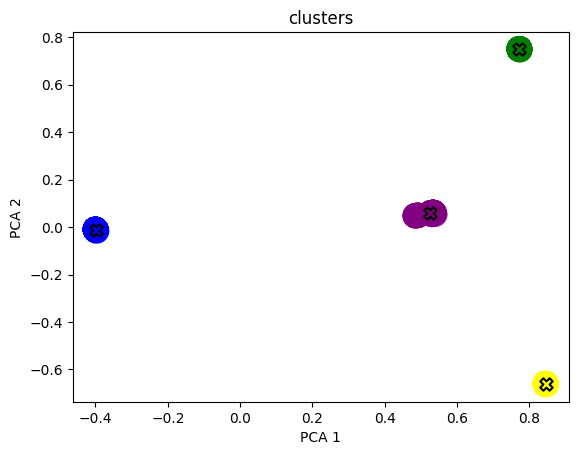

In [130]:
colors = ['purple', 'blue', 'green', 'yellow']
pca_plot(lf_data_scale, colors)

In [131]:
Cluster1 = lf_data_scale[model.labels_ == 0].copy()
Cluster2 = lf_data_scale[model.labels_ == 1].copy()
Cluster3 = lf_data_scale[model.labels_ == 2].copy()
Cluster4 = lf_data_scale[model.labels_ == 3].copy()

Cluster1_inv = scale.inverse_transform(Cluster1)
Cluster2_inv = scale.inverse_transform(Cluster2)
Cluster3_inv = scale.inverse_transform(Cluster3)
Cluster4_inv = scale.inverse_transform(Cluster4)


### Cluster 1

In [132]:
Cluster1_inv = pd.DataFrame(Cluster1_inv,columns=Cluster1.columns)
Cluster1_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
count,118.000000,118.0,118.0,118.000000,118.000000,118.0,118.000000,118.000000,118.000000
mean,250.364095,0.0,0.0,0.093220,0.262712,0.0,0.296610,0.288136,0.059322
std,246.809846,0.0,0.0,0.291981,0.441984,0.0,0.458711,0.454826,0.237234
min,67.380100,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,104.813500,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,197.149200,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,229.582600,0.0,0.0,0.000000,1.000000,0.0,1.000000,1.000000,0.000000
max,1530.559500,0.0,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [133]:
print("Mean Revenue in Cluster 1: {}".format(np.array(Cluster1_inv['sales']).mean()))
print("SD Revenue in Cluster 1: {}".format(np.array(Cluster1_inv['sales']).std()))
print("Customers in Cluster 1: {} ".format(Cluster1_inv.shape[0]))
print("Cluster 1 Coffee: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Coffee'] == 1.0)].shape[0]))
print("Cluster 1 Coffee (Bottle): {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("Cluster 1 Honey: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Honey1'] == 1.0)].shape[0]))
print("Cluster 1 Juice: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Juice'] == 1.0)].shape[0]))
print("Cluster 1 Salad: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Salad'] == 1.0)].shape[0]))
print("Cluster 1 Salmon Steak: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("Cluster 1 Soup: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Soup'] == 1.0)].shape[0]))
print("Cluster 1 Tea: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Tea'] == 1.0)].shape[0]))



Mean Revenue in Cluster 1: 250.36409491525424
SD Revenue in Cluster 1: 245.76181680759072
Customers in Cluster 1: 118 
Cluster 1 Coffee: 0 
Cluster 1 Coffee (Bottle): 0 
Cluster 1 Honey: 11 
Cluster 1 Juice: 31 
Cluster 1 Salad: 0 
Cluster 1 Salmon Steak: 35 
Cluster 1 Soup: 34 
Cluster 1 Tea: 7 


### Cluster 2

In [134]:
Cluster2_inv = pd.DataFrame(Cluster2_inv,columns=Cluster2.columns)
Cluster2_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
count,666.000000,666.0,666.0,666.0,666.0,666.0,666.0,666.0,666.0
mean,163.986127,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
std,112.748054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,71.536400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25%,104.822400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
50%,117.291300,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
75%,209.627000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
max,1166.207800,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [135]:
print("Mean Revenue in Cluster 2: {}".format(np.array(Cluster2_inv['sales']).mean()))
print("SD Revenue in Cluster 2: {}".format(np.array(Cluster2_inv['sales']).std()))
print("Customers in Cluster 2: {} ".format(Cluster2_inv.shape[0]))
print("Cluster 2 Coffee: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Coffee'] == 1.0)].shape[0]))
print("Cluster 2 Coffee (Bottle): {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("Cluster 2 Honey1: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Honey1'] == 1.0)].shape[0]))
print("Cluster 2 Juice: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Juice'] == 1.0)].shape[0]))
print("Cluster 2 Salad: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Salad'] == 1.0)].shape[0]))
print("Cluster 2 Salmon Steak: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("Cluster 2 Soup: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Soup'] == 1.0)].shape[0]))
print("Cluster 2 Tea: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Tea'] == 1.0)].shape[0]))



Mean Revenue in Cluster 2: 163.98612732732735
SD Revenue in Cluster 2: 112.66337617303247
Customers in Cluster 2: 666 
Cluster 2 Coffee: 0 
Cluster 2 Coffee (Bottle): 0 
Cluster 2 Honey1: 0 
Cluster 2 Juice: 0 
Cluster 2 Salad: 666 
Cluster 2 Salmon Steak: 0 
Cluster 2 Soup: 0 
Cluster 2 Tea: 0 


### Cluster 3

In [136]:
Cluster3_inv = pd.DataFrame(Cluster3_inv,columns=Cluster3.columns)
Cluster3_inv.describe()


,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
count,118.000000,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0
mean,132.475081,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,99.036471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,59.067500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,79.866800,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,96.492000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,151.400975,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,758.694500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
print("Mean Revenue in Cluster 3: {}".format(np.array(Cluster3_inv['sales']).mean()))
print("SD Revenue in Cluster 3: {}".format(np.array(Cluster3_inv['sales']).std()))
print("Customers in Cluster 3: {} ".format(Cluster3_inv.shape[0]))
print("Cluster 3 Coffee: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Coffee'] == 1.0)].shape[0]))
print("Cluster 3 Coffee (Bottle): {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("Cluster 3 Honey1: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Honey1'] == 1.0)].shape[0]))
print("Cluster 3 Juice: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Juice'] == 1.0)].shape[0]))
print("Cluster 3 Salad: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Salad'] == 1.0)].shape[0]))
print("Cluster 3 Salmon Steak: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("Cluster 3 Soup: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Soup'] == 1.0)].shape[0]))
print("Cluster 3 Tea: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Tea'] == 1.0)].shape[0]))



Mean Revenue in Cluster 3: 132.47508050847458
SD Revenue in Cluster 3: 98.6159325057365
Customers in Cluster 3: 118 
Cluster 3 Coffee: 118 
Cluster 3 Coffee (Bottle): 0 
Cluster 3 Honey1: 0 
Cluster 3 Juice: 0 
Cluster 3 Salad: 0 
Cluster 3 Salmon Steak: 0 
Cluster 3 Soup: 0 
Cluster 3 Tea: 0 


### Cluster 4

In [138]:
Cluster4_inv = pd.DataFrame(Cluster4_inv,columns=Cluster4.columns)
Cluster4_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea
count,134.000000,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0
mean,157.799323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
std,135.695232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,45.744200,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,79.857900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,79.857900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,159.715800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
max,908.312600,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
print("Mean Revenue in Cluster 4: {}".format(np.array(Cluster4_inv['sales']).mean()))
print("SD Revenue in Cluster 4: {}".format(np.array(Cluster4_inv['sales']).std()))
print("Customers in Cluster 4: {} ".format(Cluster4_inv.shape[0]))
print("Cluster 4 Coffee: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Coffee'] == 1.0)].shape[0]))
print("Cluster 4 Coffee (Bottle): {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("Cluster 4 Honey1: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Honey1'] == 1.0)].shape[0]))
print("Cluster 4 Juice: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Juice'] == 1.0)].shape[0]))
print("Cluster 4 Salad: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Salad'] == 1.0)].shape[0]))
print("Cluster 4 Salmon Steak: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("Cluster 4 Soup: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Soup'] == 1.0)].shape[0]))
print("Cluster 4 Tea: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Tea'] == 1.0)].shape[0]))



Mean Revenue in Cluster 4: 157.79932313432838
SD Revenue in Cluster 4: 135.18795803043608
Customers in Cluster 4: 134 
Cluster 4 Coffee: 0 
Cluster 4 Coffee (Bottle): 134 
Cluster 4 Honey1: 0 
Cluster 4 Juice: 0 
Cluster 4 Salad: 0 
Cluster 4 Salmon Steak: 0 
Cluster 4 Soup: 0 
Cluster 4 Tea: 0 


### Experiment 1 Summary

The k-means clustering technique is used to group data into four main categories: salad, bottled coffee, cupped coffee, and other types of food. The salad group has the highest number of customers, with 666 people, making it the most popular menu item in the restaurant. However, the average bill for customers in this group is 164 baht. On the other hand, the group with the highest total bill is the "other food" group, with an average bill of 250 baht, despite having only 118 people. Therefore, the restaurant should consider promoting menu items from this food category to stimulate an increase in the number of customers in this group, leading to higher revenue for the restaurant.

Regarding the coffee menu groups, it is found that bottled coffee is more popular and has a higher average bill compared to cupped coffee.

## Experiment 2

menu category and time_of_day clustering

In [140]:
lf_data = lf_data_ori[['member_id', 'sales', 'category', 'time_of_day']].copy()
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   member_id    1603 non-null   object 
 1   sales        2800 non-null   float64
 2   category     2748 non-null   object 
 3   time_of_day  2800 non-null   object 
dtypes: float64(1), object(3)
memory usage: 87.6+ KB


,member_id,sales,category,time_of_day
0,None,79.8579,Coffee (Bottle),1_Noon
1,14bc04ee,79.8579,Coffee (Bottle),0_Morning
2,None,79.8579,Coffee (Bottle),0_Morning
3,8e60e131,79.8579,Coffee (Bottle),2_Afternoon
4,2c156018,79.8579,Coffee (Bottle),2_Afternoon


In [141]:
lf_data = lf_data.dropna()
lf_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1574 entries, 1 to 2797
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   member_id    1574 non-null   object 
 1   sales        1574 non-null   float64
 2   category     1574 non-null   object 
 3   time_of_day  1574 non-null   object 
dtypes: float64(1), object(3)
memory usage: 61.5+ KB


In [142]:
aggregations = {
    'sales': 'sum',
    'category': 'max',
    'time_of_day': 'max'
}
lf_data = lf_data.groupby('member_id').agg(aggregations).reset_index()
lf_data.info()
lf_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   member_id    1036 non-null   object 
 1   sales        1036 non-null   float64
 2   category     1036 non-null   object 
 3   time_of_day  1036 non-null   object 
dtypes: float64(1), object(3)
memory usage: 32.5+ KB


,member_id,sales,category,time_of_day
0,004a4488,234.5826,Salad,2_Afternoon
1,009e11b6,71.5453,Salad,2_Afternoon
2,00f07ddd,209.6270,Salad,2_Afternoon
3,00f0e4d4,117.2913,Salad,2_Afternoon
4,0100b137,117.3002,Salad,3_Evening


In [143]:
lf_data = lf_data.drop('member_id', axis=1)
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales        1036 non-null   float64
 1   category     1036 non-null   object 
 2   time_of_day  1036 non-null   object 
dtypes: float64(1), object(2)
memory usage: 24.4+ KB


,sales,category,time_of_day
0,234.5826,Salad,2_Afternoon
1,71.5453,Salad,2_Afternoon
2,209.6270,Salad,2_Afternoon
3,117.2913,Salad,2_Afternoon
4,117.3002,Salad,3_Evening


In [144]:
lf_data = pd.get_dummies(lf_data, columns=['category'], prefix=['category'])
lf_data = lf_data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

lf_data = pd.get_dummies(lf_data, columns=['time_of_day'], prefix=['time_of_day'])
lf_data = lf_data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sales                     1036 non-null   float64
 1   category_Coffee           1036 non-null   int32  
 2   category_Coffee (Bottle)  1036 non-null   int32  
 3   category_Honey1           1036 non-null   int32  
 4   category_Juice            1036 non-null   int32  
 5   category_Salad            1036 non-null   int32  
 6   category_Salmon Steak     1036 non-null   int32  
 7   category_Soup             1036 non-null   int32  
 8   category_Tea              1036 non-null   int32  
 9   time_of_day_0_Morning     1036 non-null   int32  
 10  time_of_day_1_Noon        1036 non-null   int32  
 11  time_of_day_2_Afternoon   1036 non-null   int32  
 12  time_of_day_3_Evening     1036 non-null   int32  
dtypes: float64(1), int32(12)
memory usage: 56.8 KB


,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
0,234.5826,0,0,0,0,1,0,0,0,0,0,1,0
1,71.5453,0,0,0,0,1,0,0,0,0,0,1,0
2,209.6270,0,0,0,0,1,0,0,0,0,0,1,0
3,117.2913,0,0,0,0,1,0,0,0,0,0,1,0
4,117.3002,0,0,0,0,1,0,0,0,0,0,0,1


In [145]:
scale = MinMaxScaler()
lf_data_scale = lf_data.copy()
lf_data_scale[lf_data_scale.columns] = scale.fit_transform(lf_data)
lf_data_scale.head()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
0,0.127180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.017377,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.110373,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.048186,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.048192,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Silhouette_coef

[2, 3, 4, 5, 6, 7, 8, 9, 10] [0.3449092342143386, 0.4151792681851099, 0.4327370525826068, 0.5042228579834824, 0.6231528004220974, 0.6741842005674507, 0.7133982194501961, 0.7303945454724081, 0.7511866648394535]


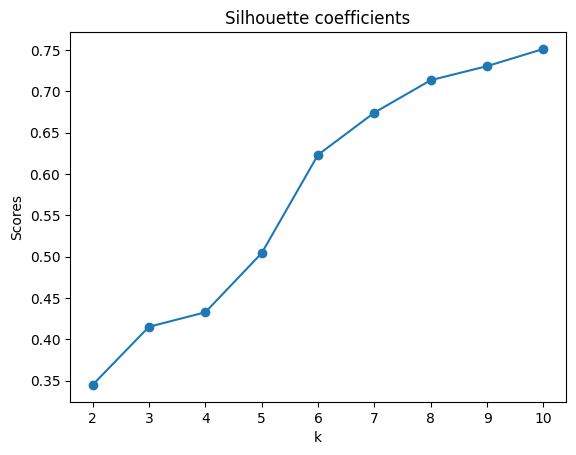

In [146]:
Silhouette_coef(lf_data_scale)

### wcss

[2, 3, 4, 5, 6, 7, 8, 9, 10] [995.8696938742105, 788.273733176907, 729.4957560024202, 575.7105220223214, 415.4816826730038, 348.9425625490221, 275.1150155949992, 265.3844278589589, 238.7141639932637]


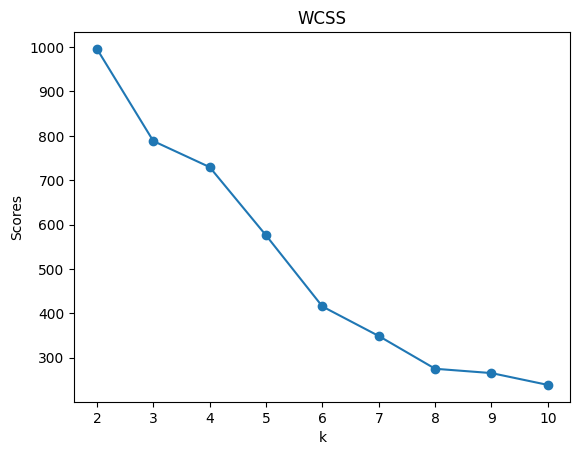

In [147]:
wcss(lf_data_scale)

### kmean

In [148]:
kmeans = KMeans(n_clusters=6, random_state=1,)
model = kmeans.fit(lf_data_scale)
labels = model.labels_

### pca plot

Explained variation per principal component: [0.29024999 0.24621482]
Cumulative variance explained by 2 principal components: 53.65%


          sales  category_Coffee  category_Coffee (Bottle)  category_Honey1  \
PC_1  0.001839         0.146394                  0.007310         0.008516   
PC_2  0.002741         0.274222                  0.357942         0.014814   

      category_Juice  category_Salad  category_Salmon Steak  category_Soup  \
PC_1        0.009857        0.164654               0.015219       0.011388   
PC_2        0.044443        0.812734               0.056090       0.052896   

      category_Tea  time_of_day_0_Morning  time_of_day_1_Noon  \
PC_1      0.003592               0.047896            0.671054   
PC_2      0.012327               0.253832            0.245552   

      time_of_day_2_Afternoon  time_of_day_3_Evening   
PC_1                 0.705745                0.013205  
PC_2                 0.035135                0.043414  

*************** Most importan

c:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


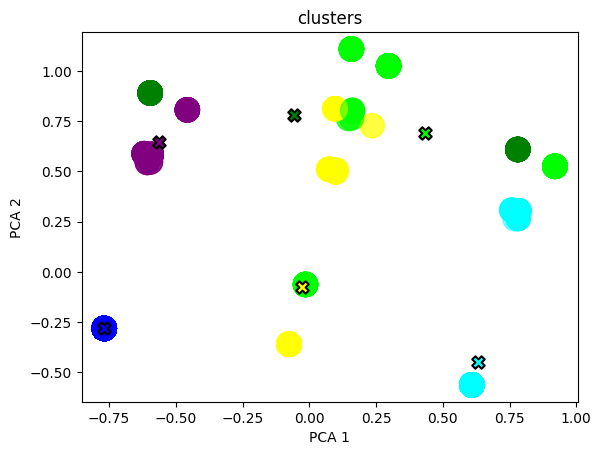

In [149]:
colors = ['purple', 'blue', 'cyan', 'green', 'lime', 'yellow']
pca_plot(lf_data_scale, colors)

In [150]:
Cluster1 = lf_data_scale[model.labels_ == 0].copy()
Cluster2 = lf_data_scale[model.labels_ == 1].copy()
Cluster3 = lf_data_scale[model.labels_ == 2].copy()
Cluster4 = lf_data_scale[model.labels_ == 3].copy()
Cluster5 = lf_data_scale[model.labels_ == 4].copy()
Cluster6 = lf_data_scale[model.labels_ == 5].copy()


Cluster1_inv = scale.inverse_transform(Cluster1)
Cluster2_inv = scale.inverse_transform(Cluster2)
Cluster3_inv = scale.inverse_transform(Cluster3)
Cluster4_inv = scale.inverse_transform(Cluster4)
Cluster5_inv = scale.inverse_transform(Cluster5)
Cluster6_inv = scale.inverse_transform(Cluster6)


### Cluster 1

In [151]:
Cluster1_inv = pd.DataFrame(Cluster1_inv,columns=Cluster1.columns)
Cluster1_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,66.000000,66.000000,66.0,66.000000,66.000000,66.0,66.000000,66.000000,66.000000,66.0,66.0,66.0,66.0
mean,184.911141,0.287879,0.0,0.045455,0.151515,0.0,0.272727,0.181818,0.060606,0.0,0.0,1.0,0.0
std,130.387564,0.456244,0.0,0.209895,0.361298,0.0,0.448775,0.388650,0.240435,0.0,0.0,0.0,0.0
min,67.380100,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
25%,96.492000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
50%,148.903200,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
75%,229.582600,1.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,1.0,0.0
max,758.694500,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,0.0,1.0,0.0


In [152]:
print('Customers in the afternoon group')
print("Mean Revenue in Cluster 1: {}".format(np.array(Cluster1_inv['sales']).mean()))
print("SD Revenue in Cluster 1: {}".format(np.array(Cluster1_inv['sales']).std()))
print("Customers in cluster 1: {} ".format(Cluster1_inv.shape[0]))
print("Cluster 1 Coffee: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Coffee'] == 1.0)].shape[0]))
print("Cluster 1 Coffee (Bottle): {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("Cluster 1 Honey1: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Honey1'] == 1.0)].shape[0]))
print("Cluster 1 Juice: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Juice'] == 1.0)].shape[0]))
print("Cluster 1 Salad: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Salad'] == 1.0)].shape[0]))
print("Cluster 1 Salmon Steak: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("Cluster 1 Soup: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Soup'] == 1.0)].shape[0]))
print("Cluster 1 Tea: {} ".format(Cluster1_inv.loc[(Cluster1_inv['category_Tea'] == 1.0)].shape[0]))

Customers in the afternoon group
Mean Revenue in Cluster 1: 184.9111409090909
SD Revenue in Cluster 1: 129.39600959950366
Customers in cluster 1: 66 
Cluster 1 Coffee: 19 
Cluster 1 Coffee (Bottle): 0 
Cluster 1 Honey1: 3 
Cluster 1 Juice: 10 
Cluster 1 Salad: 0 
Cluster 1 Salmon Steak: 18 
Cluster 1 Soup: 12 
Cluster 1 Tea: 4 


### Cluster 2

In [153]:
Cluster2_inv = pd.DataFrame(Cluster2_inv,columns=Cluster2.columns)
Cluster2_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,263.000000,263.0,263.0,263.0,263.0,263.0,263.0,263.0,263.0,263.0,263.0,263.0,263.0
mean,161.962260,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
std,97.638408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,71.536400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,117.291300,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50%,117.291300,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
75%,209.627000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
max,769.440500,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [154]:
print('Customers in the afternoon group')
print("Mean Revenue in Cluster 2: {}".format(np.array(Cluster2_inv['sales']).mean()))
print("SD Revenue in Cluster 2: {}".format(np.array(Cluster2_inv['sales']).std()))
print("Customers in cluster 2: {} ".format(Cluster2_inv.shape[0]))
print("Cluster 2 Coffee: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Coffee'] == 1.0)].shape[0]))
print("Cluster 2 Coffee (Bottle): {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("Cluster 2 Honey1: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Honey1'] == 1.0)].shape[0]))
print("Cluster 2 Juice: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Juice'] == 1.0)].shape[0]))
print("Cluster 2 Salad: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Salad'] == 1.0)].shape[0]))
print("Cluster 2 Salmon Steak: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("Cluster 2 Soup: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Soup'] == 1.0)].shape[0]))
print("Cluster 2 Tea: {} ".format(Cluster2_inv.loc[(Cluster2_inv['category_Tea'] == 1.0)].shape[0]))

Customers in the afternoon group
Mean Revenue in Cluster 2: 161.96225969581752
SD Revenue in Cluster 2: 97.45260730940196
Customers in cluster 2: 263 
Cluster 2 Coffee: 0 
Cluster 2 Coffee (Bottle): 0 
Cluster 2 Honey1: 0 
Cluster 2 Juice: 0 
Cluster 2 Salad: 263 
Cluster 2 Salmon Steak: 0 
Cluster 2 Soup: 0 
Cluster 2 Tea: 0 


### Cluster 3

In [155]:
Cluster3_inv = pd.DataFrame(Cluster3_inv,columns=Cluster3.columns)
Cluster3_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,283.000000,283.0,283.0,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.0,283.0,283.0,283.0
mean,172.282055,0.0,0.0,0.021201,0.038869,0.869258,0.021201,0.045936,0.003534,0.0,1.0,0.0,0.0
std,145.221668,0.0,0.0,0.144310,0.193626,0.337715,0.144310,0.209718,0.059444,0.0,0.0,0.0,0.0
min,67.380100,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
25%,104.813500,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
50%,117.291300,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
75%,211.705150,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
max,1162.104800,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,0.0,0.0


In [156]:
print('Customers in the evening group')
print("Mean Revenue in Cluster 3: {}".format(np.array(Cluster3_inv['sales']).mean()))
print("SD Revenue in Cluster 3: {}".format(np.array(Cluster3_inv['sales']).std()))
print("Customers in cluster 3: {} ".format(Cluster3_inv.shape[0]))
print("Cluster 3 Coffee: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Coffee'] == 1.0)].shape[0]))
print("Cluster 3 Coffee (Bottle): {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("Cluster 3 Honey1: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Honey1'] == 1.0)].shape[0]))
print("Cluster 3 Juice: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Juice'] == 1.0)].shape[0]))
print("Cluster 3 Salad: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Salad'] == 1.0)].shape[0]))
print("Cluster 3 Salmon Steak: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("Cluster 3 Soup: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Soup'] == 1.0)].shape[0]))
print("Cluster 3 Tea: {} ".format(Cluster3_inv.loc[(Cluster3_inv['category_Tea'] == 1.0)].shape[0]))

Customers in the evening group
Mean Revenue in Cluster 3: 172.2820554770318
SD Revenue in Cluster 3: 144.96486544939478
Customers in cluster 3: 283 
Cluster 3 Coffee: 0 
Cluster 3 Coffee (Bottle): 0 
Cluster 3 Honey1: 6 
Cluster 3 Juice: 11 
Cluster 3 Salad: 246 
Cluster 3 Salmon Steak: 6 
Cluster 3 Soup: 13 
Cluster 3 Tea: 1 


### Cluster 4

In [157]:
Cluster4_inv = pd.DataFrame(Cluster4_inv,columns=Cluster4.columns)
Cluster4_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,79.000000,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.0,79.000000,79.000000,79.0
mean,143.074548,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.392405,0.607595,0.0
std,136.085450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491406,0.491406,0.0
min,45.744200,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
25%,79.857900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
50%,79.857900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0
75%,157.224700,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0
max,908.312600,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0


In [158]:
print('Customers in the noon group')
print("Mean Revenue in Cluster 4: {}".format(np.array(Cluster4_inv['sales']).mean()))
print("SD Revenue in Cluster 4: {}".format(np.array(Cluster4_inv['sales']).std()))
print("Customers in cluster 4: {} ".format(Cluster4_inv.shape[0]))
print("Cluster 4 Coffee: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Coffee'] == 1.0)].shape[0]))
print("Cluster 4 Coffee (Bottle): {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("Cluster 4 Honey1: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Honey1'] == 1.0)].shape[0]))
print("Cluster 4 Juice: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Juice'] == 1.0)].shape[0]))
print("Cluster 4 Salad: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Salad'] == 1.0)].shape[0]))
print("Cluster 4 Salmon Steak: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("Cluster 4 Soup: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Soup'] == 1.0)].shape[0]))
print("Cluster 4 Tea: {} ".format(Cluster4_inv.loc[(Cluster4_inv['category_Tea'] == 1.0)].shape[0]))

Customers in the noon group
Mean Revenue in Cluster 4: 143.07454810126586
SD Revenue in Cluster 4: 135.221406916134
Customers in cluster 4: 79 
Cluster 4 Coffee: 0 
Cluster 4 Coffee (Bottle): 79 
Cluster 4 Honey1: 0 
Cluster 4 Juice: 0 
Cluster 4 Salad: 0 
Cluster 4 Salmon Steak: 0 
Cluster 4 Soup: 0 
Cluster 4 Tea: 0 


### Cluster 5

In [159]:
Cluster5_inv = pd.DataFrame(Cluster5_inv,columns=Cluster5.columns)
Cluster5_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.0,161.000000,161.000000,161.000000,161.000000,161.0,161.0
mean,138.427397,0.602484,0.186335,0.012422,0.006211,0.149068,0.0,0.031056,0.012422,0.652174,0.347826,0.0,0.0
std,94.338818,0.490911,0.390592,0.111107,0.078811,0.357267,0.0,0.174010,0.111107,0.477767,0.477767,0.0,0.0
min,59.067500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,79.857900,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,96.492000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0
75%,159.724700,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.0,0.0
max,618.037300,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0


In [160]:
print('Customers in the noon group')
print("Mean Revenue in Cluster 5: {}".format(np.array(Cluster5_inv['sales']).mean()))
print("SD Revenue in Cluster 5: {}".format(np.array(Cluster5_inv['sales']).std()))
print("Customers in cluster 5: {} ".format(Cluster5_inv.shape[0]))
print("Cluster 5 Coffee: {} ".format(Cluster5_inv.loc[(Cluster5_inv['category_Coffee'] == 1.0)].shape[0]))
print("Cluster 5 Coffee (Bottle): {} ".format(Cluster5_inv.loc[(Cluster5_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("Cluster 5 Honey1: {} ".format(Cluster5_inv.loc[(Cluster5_inv['category_Honey1'] == 1.0)].shape[0]))
print("Cluster 5 Juice: {} ".format(Cluster5_inv.loc[(Cluster5_inv['category_Juice'] == 1.0)].shape[0]))
print("Cluster 5 Salad: {} ".format(Cluster5_inv.loc[(Cluster5_inv['category_Salad'] == 1.0)].shape[0]))
print("Cluster 5 Salmon Steak: {} ".format(Cluster5_inv.loc[(Cluster5_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("Cluster 5 Soup: {} ".format(Cluster5_inv.loc[(Cluster5_inv['category_Soup'] == 1.0)].shape[0]))
print("Cluster 5 Tea: {} ".format(Cluster5_inv.loc[(Cluster5_inv['category_Tea'] == 1.0)].shape[0]))

Customers in the noon group
Mean Revenue in Cluster 5: 138.42739689440995
SD Revenue in Cluster 5: 94.04538383521859
Customers in cluster 5: 161 
Cluster 5 Coffee: 97 
Cluster 5 Coffee (Bottle): 30 
Cluster 5 Honey1: 2 
Cluster 5 Juice: 1 
Cluster 5 Salad: 24 
Cluster 5 Salmon Steak: 0 
Cluster 5 Soup: 5 
Cluster 5 Tea: 2 


### Cluster 6

In [161]:
Cluster6_inv = pd.DataFrame(Cluster6_inv,columns=Cluster6.columns)
Cluster6_inv.describe()

,sales,category_Coffee,category_Coffee (Bottle),category_Honey1,category_Juice,category_Salad,category_Salmon Steak,category_Soup,category_Tea,time_of_day_0_Morning,time_of_day_1_Noon,time_of_day_2_Afternoon,time_of_day_3_Evening
count,184.000000,184.000000,184.000000,184.0,184.000000,184.000000,184.000000,184.000000,184.0,184.0,184.0,184.0,184.0
mean,208.636746,0.010870,0.135870,0.0,0.048913,0.722826,0.059783,0.021739,0.0,0.0,0.0,0.0,1.0
std,198.428437,0.103972,0.343585,0.0,0.216275,0.448824,0.237731,0.146228,0.0,0.0,0.0,0.0,0.0
min,71.536400,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
25%,104.820175,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
50%,117.291300,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
75%,234.582600,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
max,1530.559500,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0


In [162]:
print('Customers in the morning group')
print("Mean Revenue in Cluster 6: {}".format(np.array(Cluster6_inv['sales']).mean()))
print("SD Revenue in Cluster 6: {}".format(np.array(Cluster6_inv['sales']).std()))
print("Customers in cluster 6".format(Cluster6_inv.shape[0]))
print("Cluster 6 Coffee: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Coffee'] == 1.0)].shape[0]))
print("Cluster 6 Coffee (Bottle): {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Coffee (Bottle)'] == 1.0)].shape[0]))
print("Cluster 6 Honey1: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Honey1'] == 1.0)].shape[0]))
print("Cluster 6 Juice: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Juice'] == 1.0)].shape[0]))
print("Cluster 6 Salad: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Salad'] == 1.0)].shape[0]))
print("Cluster 6 Salmon Steak: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Salmon Steak'] == 1.0)].shape[0]))
print("Cluster 6 Soup: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Soup'] == 1.0)].shape[0]))
print("Cluster 6 Tea: {} คน".format(Cluster6_inv.loc[(Cluster6_inv['category_Tea'] == 1.0)].shape[0]))

Customers in the morning group
Mean Revenue in Cluster 6: 208.63674619565217
SD Revenue in Cluster 6: 197.88849461550637
Customers in cluster 6
Cluster 6 Coffee: 2 คน
Cluster 6 Coffee (Bottle): 25 คน
Cluster 6 Honey1: 0 คน
Cluster 6 Juice: 9 คน
Cluster 6 Salad: 133 คน
Cluster 6 Salmon Steak: 11 คน
Cluster 6 Soup: 4 คน
Cluster 6 Tea: 0 คน


### Experiment 2 Summary

Using k-means clustering, the data is grouped into 6 main categories based on menu types:

1.Morning Customers: This group has the highest proportion of coffee purchases compared to other food items.

2.Noon Salad Customers: This group is larger than the non-salad group at lunchtime, but the non-salad group has a higher average bill.

3.Noon Non-Salad Customers: This group is smaller than the salad group at lunchtime, but the non-salad group has a higher average bill.

4.Afternoon Salad Customers: This group has the highest number of customers, but the non-salad group has a higher average bill.

5.Afternoon Non-Salad Customers: This group has the highest number of customers in the afternoon, but the non-salad group has a higher average bill.

6.Evening Customers: This group has the highest average bill, approximately 208 baht.

## Experiment 3

customer characteristics clustering

In [163]:
lf_data = lf_data_ori[['member_id', 'sales', 'sex','age','location']].copy()
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  1603 non-null   object 
 1   sales      2800 non-null   float64
 2   sex        1385 non-null   object 
 3   age        1601 non-null   float64
 4   location   1601 non-null   object 
dtypes: float64(2), object(3)
memory usage: 109.5+ KB


,member_id,sales,sex,age,location
0,None,79.8579,None,NaN,None
1,14bc04ee,79.8579,F,59.0,North
2,None,79.8579,None,NaN,None
3,8e60e131,79.8579,M,57.0,North
4,2c156018,79.8579,M,41.0,North


In [164]:
lf_data = lf_data.dropna()
lf_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1385 entries, 1 to 2797
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  1385 non-null   object 
 1   sales      1385 non-null   float64
 2   sex        1385 non-null   object 
 3   age        1385 non-null   float64
 4   location   1385 non-null   object 
dtypes: float64(2), object(3)
memory usage: 64.9+ KB


In [165]:
aggregations = {
    'sales': 'sum',
    'sex': 'max', 
    'age': 'max',  
    'location': 'max',
}
lf_data = lf_data.groupby('member_id').agg(aggregations).reset_index()
lf_data.info()
lf_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   member_id  910 non-null    object 
 1   sales      910 non-null    float64
 2   sex        910 non-null    object 
 3   age        910 non-null    float64
 4   location   910 non-null    object 
dtypes: float64(2), object(3)
memory usage: 35.7+ KB


,member_id,sales,sex,age,location
0,004a4488,234.5826,F,54.0,South
1,009e11b6,71.5453,F,26.0,East
2,00f07ddd,209.6270,M,42.0,North
3,00f0e4d4,117.2913,F,23.0,South
4,012a8260,117.2913,F,30.0,West


In [166]:
lf_data = lf_data.drop('member_id', axis=1)
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     910 non-null    float64
 1   sex       910 non-null    object 
 2   age       910 non-null    float64
 3   location  910 non-null    object 
dtypes: float64(2), object(2)
memory usage: 28.6+ KB


,sales,sex,age,location
0,234.5826,F,54.0,South
1,71.5453,F,26.0,East
2,209.6270,M,42.0,North
3,117.2913,F,23.0,South
4,117.2913,F,30.0,West


In [167]:
encode = LabelEncoder()
lf_data['sex'] = encode.fit_transform(lf_data['sex'])
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     910 non-null    float64
 1   sex       910 non-null    int32  
 2   age       910 non-null    float64
 3   location  910 non-null    object 
dtypes: float64(2), int32(1), object(1)
memory usage: 25.0+ KB


,sales,sex,age,location
0,234.5826,0,54.0,South
1,71.5453,0,26.0,East
2,209.6270,1,42.0,North
3,117.2913,0,23.0,South
4,117.2913,0,30.0,West


In [168]:
lf_data = pd.get_dummies(lf_data, columns=['location'], prefix=['location'])
lf_data = lf_data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
lf_data.info()
lf_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales           910 non-null    float64
 1   sex             910 non-null    int32  
 2   age             910 non-null    float64
 3   location_East   910 non-null    int32  
 4   location_North  910 non-null    int32  
 5   location_South  910 non-null    int32  
 6   location_West   910 non-null    int32  
dtypes: float64(2), int32(5)
memory usage: 32.1 KB


,sales,sex,age,location_East,location_North,location_South,location_West
0,234.5826,0,54.0,0,0,1,0
1,71.5453,0,26.0,1,0,0,0
2,209.6270,1,42.0,0,1,0,0
3,117.2913,0,23.0,0,0,1,0
4,117.2913,0,30.0,0,0,0,1


In [169]:
scale = MinMaxScaler()
lf_data_scale = lf_data.copy()
lf_data_scale[lf_data_scale.columns] = scale.fit_transform(lf_data)
lf_data_scale.head()

,sales,sex,age,location_East,location_North,location_South,location_West
0,0.193668,0.0,0.642857,0.0,0.0,1.0,0.0
1,0.052558,0.0,0.142857,1.0,0.0,0.0,0.0
2,0.172069,1.0,0.428571,0.0,1.0,0.0,0.0
3,0.092152,0.0,0.089286,0.0,0.0,1.0,0.0
4,0.092152,0.0,0.214286,0.0,0.0,0.0,1.0


### Silhouette_coef

[2, 3, 4, 5, 6, 7, 8, 9, 10] [0.303572105138908, 0.5111306423661677, 0.5283902971835072, 0.6164281677742641, 0.6709843923702844, 0.7168617748493429, 0.7340683403358476, 0.702889391086024, 0.6616790081749898]


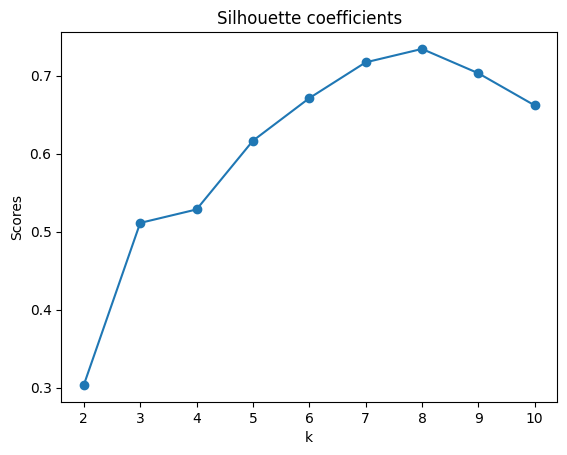

In [170]:
Silhouette_coef(lf_data_scale)

### wcss

[2, 3, 4, 5, 6, 7, 8, 9, 10] [694.761094897544, 395.5074506413762, 305.58293089479747, 192.51306747061346, 127.67268524652295, 72.37266139396174, 51.10876229158801, 48.50896835970134, 43.38804476089629]


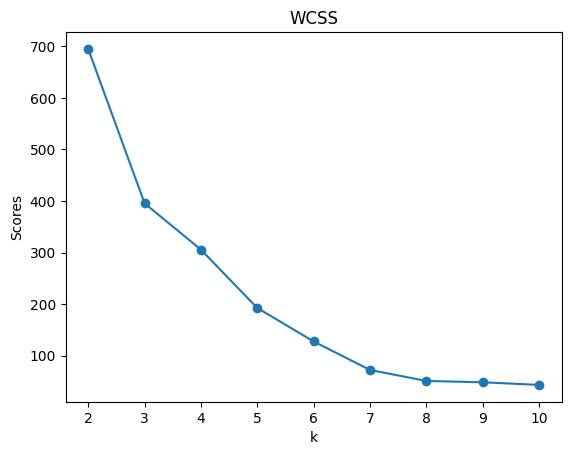

In [171]:
wcss(lf_data_scale)

### kmean

In [172]:
kmeans = KMeans(n_clusters=8, random_state=1,)
model = kmeans.fit(lf_data_scale)
labels = model.labels_

### pca plot

Explained variation per principal component: [0.32647843 0.26667396]
Cumulative variance explained by 2 principal components: 59.32%


          sales       sex       age  location_East  location_North  \
PC_1  0.002693  0.002001  0.006068       0.024916        0.796894   
PC_2  0.011031  0.060354  0.004558       0.031467        0.219577   

      location_South  location_West  
PC_1        0.568081       0.203897  
PC_2        0.587604       0.775714  

*************** Most important features *************************
As per PC 1:
 location_North    0.796894
location_South    0.568081
Name: PC_1, dtype: float64


As per PC 2:
 location_South    0.587604
location_West     0.775714
Name: PC_2, dtype: float64

******************************************************************


c:\Users\User\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


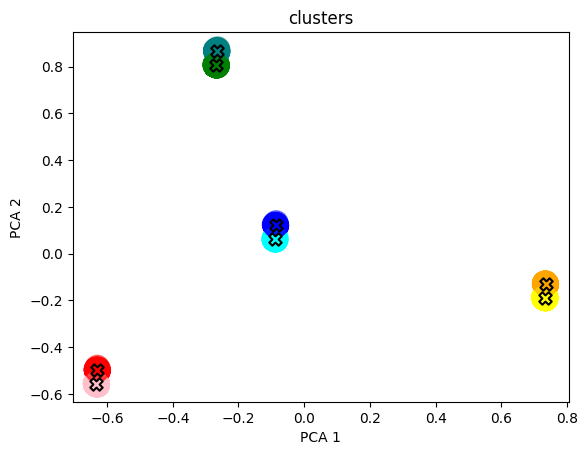

In [173]:
colors = ['orange', 'pink', 'green', 'yellow', 'blue', 'teal', 'red', 'cyan']
pca_plot(lf_data_scale, colors)

In [174]:
Cluster1 = lf_data_scale[model.labels_ == 0].copy()
Cluster2 = lf_data_scale[model.labels_ == 1].copy()
Cluster3 = lf_data_scale[model.labels_ == 2].copy()
Cluster4 = lf_data_scale[model.labels_ == 3].copy()
Cluster5 = lf_data_scale[model.labels_ == 4].copy()
Cluster6 = lf_data_scale[model.labels_ == 5].copy()
Cluster7 = lf_data_scale[model.labels_ == 6].copy()
Cluster8 = lf_data_scale[model.labels_ == 7].copy()


Cluster1_inv = scale.inverse_transform(Cluster1)
Cluster2_inv = scale.inverse_transform(Cluster2)
Cluster3_inv = scale.inverse_transform(Cluster3)
Cluster4_inv = scale.inverse_transform(Cluster4)
Cluster5_inv = scale.inverse_transform(Cluster5)
Cluster6_inv = scale.inverse_transform(Cluster6)
Cluster7_inv = scale.inverse_transform(Cluster7)
Cluster8_inv = scale.inverse_transform(Cluster8)


### Cluster 1

In [175]:
Cluster1_inv = pd.DataFrame(Cluster1_inv,columns=Cluster1.columns)
Cluster1_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,132.000000,132.0,132.000000,132.0,132.0,132.0,132.0
mean,149.070942,1.0,42.484848,0.0,1.0,0.0,0.0
std,90.635782,0.0,11.303911,0.0,0.0,0.0,0.0
min,67.380100,1.0,18.000000,0.0,1.0,0.0,0.0
25%,96.492000,1.0,36.000000,0.0,1.0,0.0,0.0
50%,117.291300,1.0,41.000000,0.0,1.0,0.0,0.0
75%,210.877000,1.0,50.000000,0.0,1.0,0.0,0.0
max,561.500900,1.0,70.000000,0.0,1.0,0.0,0.0


In [176]:
print("Mean Revenue in Cluster 1 {}".format(np.array(Cluster1_inv['sales']).mean()))
print("SD Revenue in Cluster 1: {}".format(np.array(Cluster1_inv['sales']).std()))
print("Mean age of customers in Cluster 1: {}".format(np.array(Cluster1_inv['age']).mean()))
print("Customer in Cluster 1: {} ".format(Cluster1_inv.shape[0]))
print("Man {} Woman {} ".format(Cluster1_inv.loc[(Cluster1_inv['sex'] == 1.0)].shape[0], Cluster1_inv.loc[(Cluster1_inv['sex'] == 0.0)].shape[0]))
print("North {}  South {}  East {}  West {} ".format(np.array(Cluster1_inv['location_North']).sum(), np.array(Cluster1_inv['location_South']).sum(), np.array(Cluster1_inv['location_East']).sum(), np.array(Cluster1_inv['location_West']).sum()))

Mean Revenue in Cluster 1 149.07094166666667
SD Revenue in Cluster 1: 90.29181181918054
Mean age of customers in Cluster 1: 42.484848484848484
Customer in Cluster 1: 132 
Man 132 Woman 0 
North 132.0  South 0.0  East 0.0  West 0.0 


### Cluster 2

In [177]:
Cluster2_inv = pd.DataFrame(Cluster2_inv,columns=Cluster2.columns)
Cluster2_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,162.000000,162.0,162.000000,162.0,162.0,162.0,162.0
mean,153.877531,0.0,42.629630,0.0,0.0,1.0,0.0
std,103.639521,0.0,12.161383,0.0,0.0,0.0,0.0
min,10.820600,0.0,18.000000,0.0,0.0,1.0,0.0
25%,96.494225,0.0,34.250000,0.0,0.0,1.0,0.0
50%,117.291300,0.0,42.000000,0.0,0.0,1.0,0.0
75%,196.110125,0.0,52.000000,0.0,0.0,1.0,0.0
max,758.694500,0.0,71.000000,0.0,0.0,1.0,0.0


In [178]:
print("Mean Revenue in Cluster 2: {}".format(np.array(Cluster2_inv['sales']).mean()))
print("SD Revenue in Cluster 2: {}".format(np.array(Cluster2_inv['sales']).std()))
print("Mean age of customers in Cluster 2: {}".format(np.array(Cluster2_inv['age']).mean()))
print("Customer in Cluster 2: {} ".format(Cluster2_inv.shape[0]))
print("Man {} Woman {} ".format(Cluster2_inv.loc[(Cluster2_inv['sex'] == 1.0)].shape[0], Cluster2_inv.loc[(Cluster2_inv['sex'] == 0.0)].shape[0]))
print("North {}  South {}  East {}  West {} ".format(np.array(Cluster2_inv['location_North']).sum(), np.array(Cluster2_inv['location_South']).sum(), np.array(Cluster2_inv['location_East']).sum(), np.array(Cluster2_inv['location_West']).sum()))

Mean Revenue in Cluster 2: 153.8775314814815
SD Revenue in Cluster 2: 103.31915028367827
Mean age of customers in Cluster 2: 42.629629629629626
Customer in Cluster 2: 162 
Man 0 Woman 162 
North 0.0  South 162.0  East 0.0  West 0.0 


### Cluster 3

In [179]:
Cluster3_inv = pd.DataFrame(Cluster3_inv,columns=Cluster3.columns)
Cluster3_inv.describe()


,sales,sex,age,location_East,location_North,location_South,location_West
count,136.000000,136.0,136.000000,136.0,136.0,136.0,136.0
mean,174.698919,0.0,41.426471,0.0,0.0,0.0,1.0
std,106.251835,0.0,12.106706,0.0,0.0,0.0,0.0
min,71.545300,0.0,18.000000,0.0,0.0,0.0,1.0
25%,104.813500,0.0,34.000000,0.0,0.0,0.0,1.0
50%,126.479550,0.0,42.000000,0.0,0.0,0.0,1.0
75%,214.872650,0.0,51.000000,0.0,0.0,0.0,1.0
max,619.724700,0.0,72.000000,0.0,0.0,0.0,1.0


In [180]:
print("Mean Revenue in Cluster 3: {}".format(np.array(Cluster3_inv['sales']).mean()))
print("SD Revenue in Cluster 3: {}".format(np.array(Cluster3_inv['sales']).std()))
print("Mean age of customers in Cluster 3: {}".format(np.array(Cluster3_inv['age']).mean()))
print("Customers in Cluster 3: {} ".format(Cluster3_inv.shape[0]))
print("Man {} Woman {} ".format(Cluster3_inv.loc[(Cluster3_inv['sex'] == 1.0)].shape[0], Cluster3_inv.loc[(Cluster3_inv['sex'] == 0.0)].shape[0]))
print("North {}  South {}  East {}  West {} ".format(np.array(Cluster3_inv['location_North']).sum(), np.array(Cluster3_inv['location_South']).sum(), np.array(Cluster3_inv['location_East']).sum(), np.array(Cluster3_inv['location_West']).sum()))

Mean Revenue in Cluster 3: 174.69891911764705
SD Revenue in Cluster 3: 105.86048290245566
Mean age of customers in Cluster 3: 41.4264705882353
Customers in Cluster 3: 136 
Man 0 Woman 136 
North 0.0  South 0.0  East 0.0  West 136.0 


### Cluster 4

In [181]:
Cluster4_inv = pd.DataFrame(Cluster4_inv,columns=Cluster4.columns)
Cluster4_inv.describe()


,sales,sex,age,location_East,location_North,location_South,location_West
count,194.000000,194.0,194.000000,194.0,194.0,194.0,194.0
mean,176.404344,0.0,41.211340,0.0,1.0,0.0,0.0
std,136.422369,0.0,11.187598,0.0,0.0,0.0,0.0
min,16.641200,0.0,18.000000,0.0,1.0,0.0,0.0
25%,104.813500,0.0,34.000000,0.0,1.0,0.0,0.0
50%,117.291300,0.0,41.000000,0.0,1.0,0.0,0.0
75%,209.627000,0.0,49.750000,0.0,1.0,0.0,0.0
max,1166.207800,0.0,73.000000,0.0,1.0,0.0,0.0


In [182]:
print("Mean Revenue in Cluster 4: {}".format(np.array(Cluster4_inv['sales']).mean()))
print("SD Revenue in Cluster 4: {}".format(np.array(Cluster4_inv['sales']).std()))
print("Mean age of customers in Cluster 4: {}".format(np.array(Cluster4_inv['age']).mean()))
print("Customers in Cluster 4: {} ".format(Cluster4_inv.shape[0]))
print("Man {} Woman {} ".format(Cluster4_inv.loc[(Cluster4_inv['sex'] == 1.0)].shape[0], Cluster4_inv.loc[(Cluster4_inv['sex'] == 0.0)].shape[0]))
print("North {}  South {}  East {}  West {} ".format(np.array(Cluster4_inv['location_North']).sum(), np.array(Cluster4_inv['location_South']).sum(), np.array(Cluster4_inv['location_East']).sum(), np.array(Cluster4_inv['location_West']).sum()))

Mean Revenue in Cluster 4: 176.40434381443302
SD Revenue in Cluster 4: 136.07031066850436
Mean age of customers in Cluster 4: 41.21134020618557
Customers in Cluster 4: 194 
Man 0 Woman 194 
North 194.0  South 0.0  East 0.0  West 0.0 


### Cluster 5

In [183]:
Cluster5_inv = pd.DataFrame(Cluster5_inv,columns=Cluster5.columns)
Cluster5_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,41.000000,41.0,41.000000,41.0,41.0,41.0,41.0
mean,180.571417,1.0,42.682927,1.0,0.0,0.0,0.0
std,173.719774,0.0,13.069887,0.0,0.0,0.0,0.0
min,71.545300,1.0,18.000000,1.0,0.0,0.0,0.0
25%,104.813500,1.0,37.000000,1.0,0.0,0.0,0.0
50%,117.291300,1.0,43.000000,1.0,0.0,0.0,0.0
75%,209.627000,1.0,52.000000,1.0,0.0,0.0,0.0
max,1133.774400,1.0,74.000000,1.0,0.0,0.0,0.0


In [184]:
print("Mean Revenue in Cluster 5: {}".format(np.array(Cluster5_inv['sales']).mean()))
print("SD Revenue in Cluster 5: {}".format(np.array(Cluster5_inv['sales']).std()))
print("Mean age of customers in Cluster 5: {}".format(np.array(Cluster5_inv['age']).mean()))
print("Customers in Cluster 5: {} ".format(Cluster5_inv.shape[0]))
print("Man {} Woman {} ".format(Cluster5_inv.loc[(Cluster5_inv['sex'] == 1.0)].shape[0], Cluster5_inv.loc[(Cluster5_inv['sex'] == 0.0)].shape[0]))
print("North {}  South {}  East {}  West {} ".format(np.array(Cluster5_inv['location_North']).sum(), np.array(Cluster5_inv['location_South']).sum(), np.array(Cluster5_inv['location_East']).sum(), np.array(Cluster5_inv['location_West']).sum()))

Mean Revenue in Cluster 5: 180.57141707317072
SD Revenue in Cluster 5: 171.58816278322033
Mean age of customers in Cluster 5: 42.68292682926829
Customers in Cluster 5: 41 
Man 41 Woman 0 
North 0.0  South 0.0  East 41.0  West 0.0 


### Cluster 6

In [185]:
Cluster6_inv = pd.DataFrame(Cluster6_inv,columns=Cluster6.columns)
Cluster6_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,93.000000,93.0,93.000000,93.0,93.0,93.0,93.0
mean,172.883101,1.0,43.397849,0.0,0.0,0.0,1.0
std,168.029576,0.0,11.823098,0.0,0.0,0.0,0.0
min,45.744200,1.0,18.000000,0.0,0.0,0.0,1.0
25%,96.492000,1.0,36.000000,0.0,0.0,0.0,1.0
50%,117.291300,1.0,44.000000,0.0,0.0,0.0,1.0
75%,176.358800,1.0,51.000000,0.0,0.0,0.0,1.0
max,1117.992900,1.0,72.000000,0.0,0.0,0.0,1.0


In [186]:
print("Mean Revenue in Cluster 6: {}".format(np.array(Cluster6_inv['sales']).mean()))
print("SD Revenue in Cluster 6: {}".format(np.array(Cluster6_inv['sales']).std()))
print("Mean age of customers in Cluster 6: {}".format(np.array(Cluster6_inv['age']).mean()))
print("Customers in Cluster 6: {} ".format(Cluster6_inv.shape[0]))
print("Man {} Woman {} ".format(Cluster6_inv.loc[(Cluster6_inv['sex'] == 1.0)].shape[0], Cluster6_inv.loc[(Cluster6_inv['sex'] == 0.0)].shape[0]))
print("North {}  South {}  East {}  West {} ".format(np.array(Cluster6_inv['location_North']).sum(), np.array(Cluster6_inv['location_South']).sum(), np.array(Cluster6_inv['location_East']).sum(), np.array(Cluster6_inv['location_West']).sum()))

Mean Revenue in Cluster 6: 172.88310107526883
SD Revenue in Cluster 6: 167.12374961031188
Mean age of customers in Cluster 6: 43.39784946236559
Customers in Cluster 6: 93 
Man 93 Woman 0 
North 0.0  South 0.0  East 0.0  West 93.0 


### Cluster 7

In [187]:
Cluster7_inv = pd.DataFrame(Cluster7_inv,columns=Cluster7.columns)
Cluster7_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,108.000000,108.0,108.000000,108.0,108.0,108.0,108.0
mean,159.579756,1.0,41.259259,0.0,0.0,1.0,0.0
std,138.011555,0.0,11.897829,0.0,0.0,0.0,0.0
min,10.820600,1.0,18.000000,0.0,0.0,1.0,0.0
25%,96.492000,1.0,34.500000,0.0,0.0,1.0,0.0
50%,117.291300,1.0,42.000000,0.0,0.0,1.0,0.0
75%,188.838825,1.0,50.250000,0.0,0.0,1.0,0.0
max,1161.225600,1.0,66.000000,0.0,0.0,1.0,0.0


In [188]:
print("Mean Revenue in Cluster 7: {}".format(np.array(Cluster7_inv['sales']).mean()))
print("SD Revenue in Cluster 7: {}".format(np.array(Cluster7_inv['sales']).std()))
print("Mean age of customers in Cluster 7: {}".format(np.array(Cluster7_inv['age']).mean()))
print("Customers in Cluster 7: {} ".format(Cluster7_inv.shape[0]))
print("Man {} Woman {} ".format(Cluster7_inv.loc[(Cluster7_inv['sex'] == 1.0)].shape[0], Cluster7_inv.loc[(Cluster7_inv['sex'] == 0.0)].shape[0]))
print("North {}  South {}  East {}  West {} ".format(np.array(Cluster7_inv['location_North']).sum(), np.array(Cluster7_inv['location_South']).sum(), np.array(Cluster7_inv['location_East']).sum(), np.array(Cluster7_inv['location_West']).sum()))

Mean Revenue in Cluster 7: 159.5797564814815
SD Revenue in Cluster 7: 137.37112706969265
Mean age of customers in Cluster 7: 41.25925925925926
Customers in Cluster 7: 108 
Man 108 Woman 0 
North 0.0  South 108.0  East 0.0  West 0.0 


### Cluster 8

In [189]:
Cluster8_inv = pd.DataFrame(Cluster8_inv,columns=Cluster8.columns)
Cluster8_inv.describe()

,sales,sex,age,location_East,location_North,location_South,location_West
count,44.000000,44.0,44.000000,44.0,44.0,44.0,44.0
mean,184.992332,0.0,40.250000,1.0,0.0,0.0,0.0
std,167.663611,0.0,11.582113,0.0,0.0,0.0,0.0
min,71.545300,0.0,18.000000,1.0,0.0,0.0,0.0
25%,93.374775,0.0,33.750000,1.0,0.0,0.0,0.0
50%,117.291300,0.0,39.500000,1.0,0.0,0.0,0.0
75%,223.354800,0.0,47.250000,1.0,0.0,0.0,0.0
max,928.321500,0.0,64.000000,1.0,0.0,0.0,0.0


In [190]:
print("Mean Revenue in Cluster 8: {}".format(np.array(Cluster8_inv['sales']).mean()))
print("SD Revenue in Cluster 8: {}".format(np.array(Cluster8_inv['sales']).std()))
print("Mean age of customers in Cluster 8: {}".format(np.array(Cluster8_inv['age']).mean()))
print("Customers in Cluster 8: {} ".format(Cluster8_inv.shape[0]))
print("Man {} Woman {} ".format(Cluster8_inv.loc[(Cluster8_inv['sex'] == 1.0)].shape[0], Cluster8_inv.loc[(Cluster8_inv['sex'] == 0.0)].shape[0]))
print("North {}  South {}  East {}  West {} ".format(np.array(Cluster8_inv['location_North']).sum(), np.array(Cluster8_inv['location_South']).sum(), np.array(Cluster8_inv['location_East']).sum(), np.array(Cluster8_inv['location_West']).sum()))

Mean Revenue in Cluster 8: 184.99233181818184
SD Revenue in Cluster 8: 165.74739284378964
Mean age of customers in Cluster 8: 40.25
Customers in Cluster 8: 44 
Man 0 Woman 44 
North 0.0  South 0.0  East 44.0  West 0.0 


### Experiment 3 Summary

Using k-means clustering, the data is divided into 8 clusters based on menu types, regions, and gender of the customers. The average ages in each cluster are similar. The regions are categorized from highest to lowest average bill as follows: [Eastern, Western, Northern, and Southern].

In every region, there are more female customers than male customers.

The Eastern region has the fewest customers but the highest average bill (there should be a campaign to increase the number of customers in this group).

The Northern region has the highest number of customers.

Male customers in the Northern region have the lowest average bill (efforts should be made to increase sales among this group).